In [1]:
!pip install ultralytics shap matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
from ultralytics import YOLO
import shap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torchvision
from skimage.segmentation import slic

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:

# Define the model path in your drive
model_path = '/content/drive/MyDrive/CAPSTONE_YOLO/best.pt'

print(f"Model path: {model_path}")

Model path: /content/drive/MyDrive/CAPSTONE_YOLO/best.pt


In [4]:
from ultralytics import YOLO

# Load the model
model = YOLO(model_path)
print("Model loaded successfully!")

Model loaded successfully!



image 1/1 /content/drive/MyDrive/SHAP/11.jpg: 800x800 1 FreshApple, 23.0ms
Speed: 16.1ms preprocess, 23.0ms inference, 306.5ms postprocess per image at shape (1, 3, 800, 800)


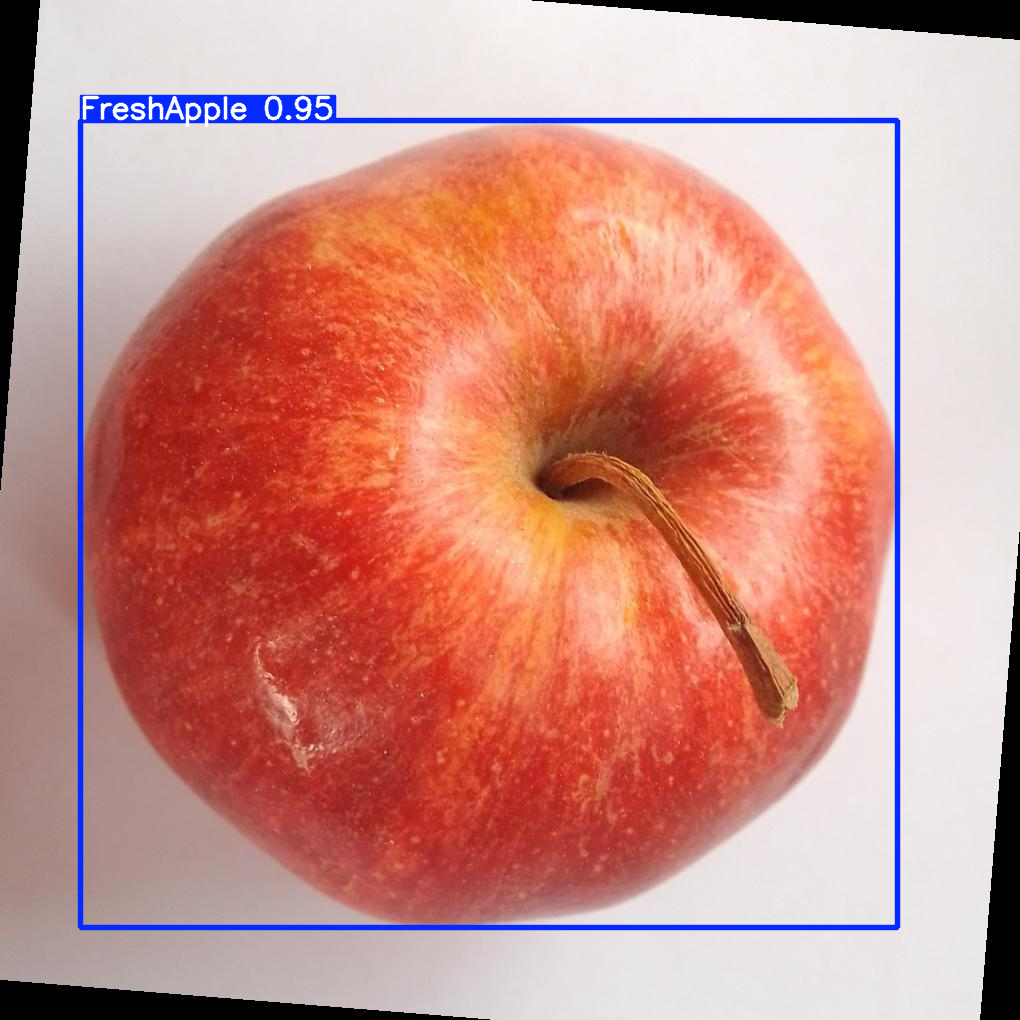

In [6]:
# Perform inference on an image
results = model.predict('/content/drive/MyDrive/SHAP/11.jpg')

# Access the first result
result = results[0]  # YOLOv8 returns a list of results

# Display the result
result.show()

In [11]:
image_paths = [
    '/content/drive/MyDrive/CAPSTONE_YOLO/img1.jpg',
    '/content/drive/MyDrive/CAPSTONE_YOLO/img2.jpg',
    '/content/drive/MyDrive/CAPSTONE_YOLO/img3.jpg',
    '/content/drive/MyDrive/CAPSTONE_YOLO/img4.jpg',
    '/content/drive/MyDrive/CAPSTONE_YOLO/img5.jpg'
]


In [12]:
# Function to preprocess images for YOLOv8 model
def preprocess_image(image):
    """Preprocess a single image for the YOLOv8 model."""
    return np.array(image.resize((640, 640))) / 255.0  # Resize to 640x640 and normalize

# Preprocess all images
images = [Image.open(path).convert('RGB') for path in image_paths]
Xtr = np.array([preprocess_image(img) for img in images])  # Batch of preprocessed images

# Define the predict function
def predict(batch):
    """
    Model prediction function for SHAP.
    Processes batch input and returns class scores for each image.
    """
    batch_scores = []
    for x in batch:
        x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Shape to (1, channels, height, width)
        results = model(x)
        predictions = results[0].boxes.data.cpu().numpy()  # Extract bounding box data

        # Aggregate scores for each class
        class_scores = np.zeros(len(class_names))
        for box in predictions:
            class_idx = int(box[5])  # Class index
            confidence = box[4]  # Confidence score
            class_scores[class_idx] += confidence  # Sum confidence scores for each class

        # Normalize scores to sum to 1 (probability-like)
        class_scores /= class_scores.sum() if class_scores.sum() > 0 else 1
        batch_scores.append(class_scores)

    return np.array(batch_scores)

In [13]:
class_names = list({
    0: 'FreshApple',
    1: 'FreshBanana',
    2: 'FreshGrape',
    3: 'FreshGuava',
    4: 'FreshJujube',
    5: 'FreshOrange',
    6: 'FreshPomegranate',
    7: 'FreshStrawberry',
    8: 'RottenApple',
    9: 'RottenBanana',
    10: 'RottenGrape',
    11: 'RottenGuava',
    12: 'RottenJujube',
    13: 'RottenOrange',
    14: 'RottenPomegranate',
    15: 'RottenStrawberry'
}.values())  # This will give you a list of class names

In [14]:
# SHAP settings
topk = 4
batch_size = 3
n_evals = 500

# Define a masker that masks out partitions of the input image
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# Create the SHAP explainer
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# Feed multiple images for explanation
shap_values = explainer(
    Xtr[:4],  # Subset of images to explain
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],  # Focus on top-k classes
)

# Transform data for visualization
shap_values.data = (shap_values.data * 255).astype(np.uint8)  # Convert back to original pixel range
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]  # Adjust shape for visualization


0: 640x640 1 FreshOrange, 42.5ms
Speed: 1.3ms preprocess, 42.5ms inference, 12.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshApple, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshApple, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshApples, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshApples, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshApple, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshApple, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshApples, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.5ms pos

  0%|          | 0/498 [00:00<?, ?it/s]


0: 640x640 1 FreshApple, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshApple, 1 FreshStrawberry, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshOrange, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshApple, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshOrange, 1 FreshPomegranate, 16.1ms
Speed: 

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]


0: 640x640 1 FreshOrange, 1 RottenOrange, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshOrange, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshOrange, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshOranges, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshOranges, 1 RottenOrange, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshOranges, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshOranges, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.0ms
Speed: 1.1m

  0%|          | 0/498 [00:00<?, ?it/s]


0: 640x640 1 FreshPomegranate, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshOrange, 1 FreshPomegranate, 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.0ms
Speed: 1.2ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenOrange, 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshOrange, 12.9ms
Speed: 1.1ms pr

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:46<00:10, 10.93s/it]


0: 640x640 1 RottenOrange, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshPomegranate, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshPomegranate, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshPomegranate, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshPomegranate, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshPomegranates, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshPomegranates, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshPomegranates, 16.0ms
Speed: 1.

  0%|          | 0/498 [00:00<?, ?it/s]


0: 640x640 1 FreshPomegranate, 13.9ms
Speed: 1.2ms preprocess, 13.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshPomegranate, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 FreshPomegranates, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenOrange, 13.8ms
Speed: 1.2ms preprocess, 13.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenOrange, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 FreshPomegranate, 14.5ms
Speed: 1.2ms preproces

PartitionExplainer explainer: 100%|██████████| 4/4 [01:08<00:00, 15.65s/it]


0: 640x640 1 FreshOrange, 1 RottenOrange, 1 RottenPomegranate, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenApple, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenApple, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenApple, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenApple, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenApple, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenApple, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 RottenApples, 15.4ms
Speed: 1.1m

  0%|          | 0/498 [00:00<?, ?it/s]


0: 640x640 1 RottenPomegranate, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenPomegranate, 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenOrange, 13.1ms
Speed: 1.1ms preprocess, 13.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 1.1ms preprocess, 13.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.2ms
Speed: 1.2ms preprocess, 13.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenOrange, 13.1ms
Speed: 1.1ms preprocess, 13.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenApple, 13.1ms
Speed: 1.1ms preprocess, 13.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 RottenOrange, 13.1ms
Speed: 1.1ms preprocess, 13.1m

PartitionExplainer explainer: 5it [01:30, 22.61s/it]


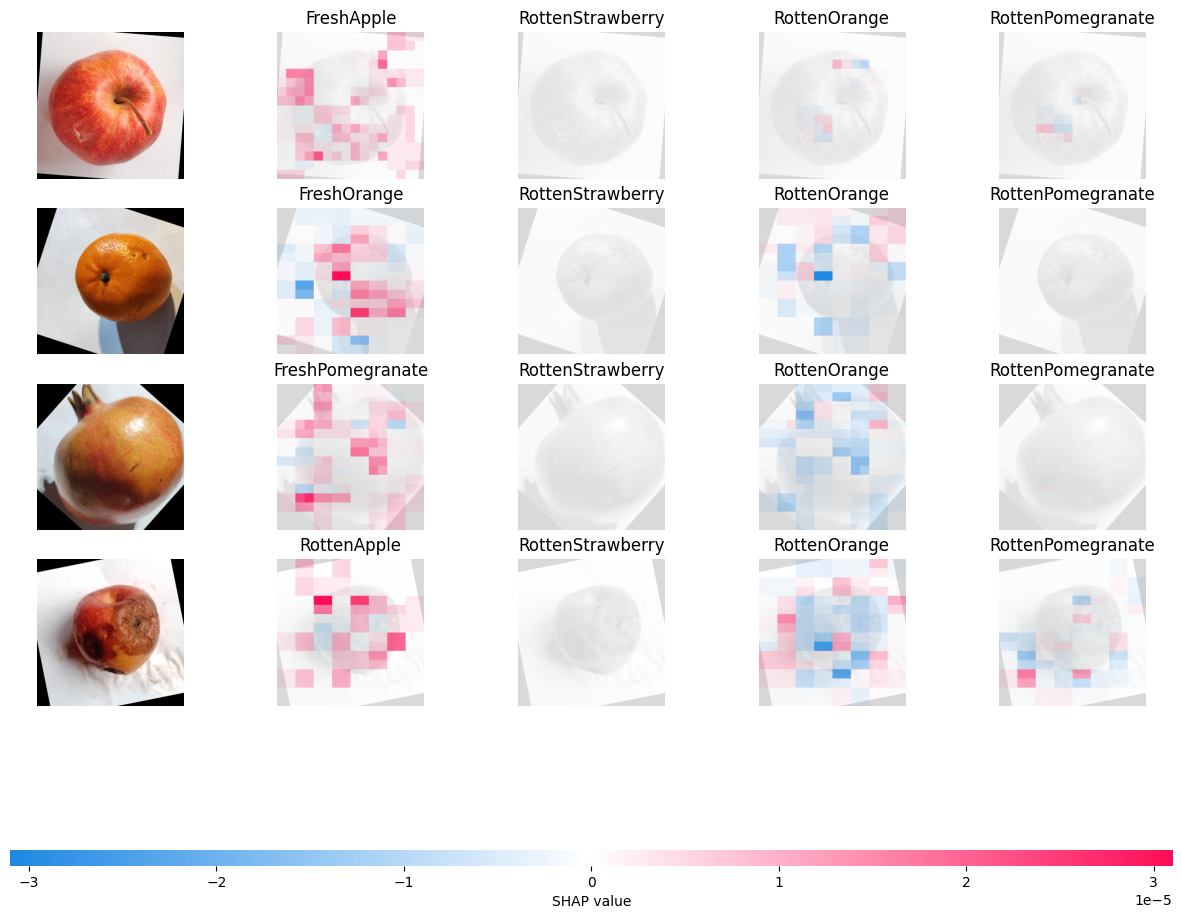

In [15]:
# Visualize SHAP values
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names
)